In [ ]:
!pip install tensorflow_text

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from unicodedata import normalize
import tensorflow_text as tf_text
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import re

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,   as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQAXJ77/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQAXJ77/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQAXJ77/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Process the data file
def process_pairs(line):
    line = tf.strings.lower(line)
    line = tf_text.normalize_utf8(line, 'NFKD')
    line = tf.strings.regex_replace(line, '[^ a-z.?!,¿]+', '')
    line = tf.strings.regex_replace(line, '[.?!,¿]', r' \0 ')
    line = tf.strings.strip(line)
    line = tf.strings.join(['startseq', line, 'endseq'], separator=' ')
    return line

In [5]:
dataset_train = train_dataset.map(lambda x, y: (process_pairs(x), y))
dataset_test = test_dataset.map(lambda x, y: (process_pairs(x), y))

In [6]:
def data_to_numpy(data):
    sentences = []
    labels = []
    
    for sentence, label in data:
        sentences.append(str(sentence.numpy()))
        labels.append(label.numpy())

    labels_np = np.array(labels)
    
    return sentences, labels_np

In [7]:
training_sentences, training_labels = data_to_numpy(dataset_train)
testing_sentences, testing_labels = data_to_numpy(dataset_test)

In [8]:
training_sentences[-200], len(training_sentences[-200]), training_labels[-200]

("b'startseq this was a great movie that had a lot of under lying issues .  it dealt with issues of rascism and class .  but ,  it also had a message of knowing yourself and taking responsibility for yourself .  this movie was very deep it gave the message of that you and only you can control your destiny .  it also showed that knowing yourself and being comfortable with who you are is the only way you will ever fit into society .  what others think of you is not important .  i believe this movie did a wonderful job of showing it .  the actors i think were able to convey each character wonderfully .  i just thought it was amazing how deep this movie really was .  at a just glancing look you wouldnt see how deep the movie is ,  but on further look you see the underlining meaning of the movie . endseq'",
 809,
 1)

In [9]:
training_sentences[-1], len(training_sentences[-1]),  training_labels[-1]

("b'startseq first of all ,  riget is wonderful .  good comedy and mystery thriller at the same time .  nice combination of strange dogma style of telling the story together with good music and great actors .  but unfortunately theres no the end .  as for me its unacceptable .  i was thinking .  .  .  how it will be possible to continue the story without helmer and drusse ?   .  .  . and i have some idea .  i think lars should make riget iii a little bit different .  im sure that rd part without helmer wouldnt be the same .  so heres my suggestion .  mayble little bit stupid ,  maybe not .  i know that lars likes to experiment .  so why not to make small experiment with riget ?  i think the only solution here is to create puppetdriven animation like for example team america by trey parker or even computer d animation .  i know its not the same as real actors ,  but in principle i believe it could work .  .  .  only this way its possible to make actors alive again .  for riget fans this

In [10]:
training_sentences[1], len(training_sentences[1]), training_labels[1]

("b'startseq i have been known to fall asleep during films ,  but this is usually due to a combination of things including ,  really tired ,  being warm and comfortable on the sette and having just eaten a lot .  however on this occasion i fell asleep because the film was rubbish .  the plot development was constant .  constantly slow and boring .  things seemed to happen ,  but with no explanation of what was causing them or why .  i admit ,  i may have missed part of the film ,  but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else .  i cant recommend this film at all . endseq'",
 661,
 0)

In [11]:
testing_sentences, val_sentences, testing_labels, val_labels = train_test_split(testing_sentences, testing_labels, test_size=5000, random_state=42)

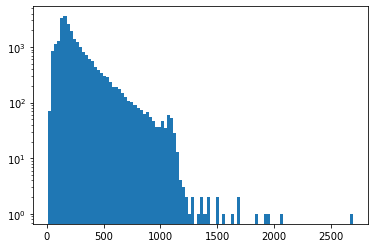

In [14]:
plt.hist([len(s.split()) for s in training_sentences],log=True, bins=100)
plt.show()

In [ ]:
max_length = 120
vocab_size = 10000
oov_tok = "<OOV>"

lang_tokenizer = tf.keras.preprocessing.text.Tokenizer()
lang_tokenizer.fit_on_texts(training_sentences)
tensor = lang_tokenizer.texts_to_sequences(training_sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=max_length, padding='post')


testing_sequences = lang_tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences,maxlen=max_length,  padding='post')


val_sequences = lang_tokenizer.texts_to_sequences(val_sentences)
val_padded = tf.keras.preprocessing.sequence.pad_sequences(val_sequences,maxlen=max_length,  padding='post')

In [ ]:
seq_len = padded.shape[1]
testing_padded.shape, padded.shape, val_padded.shape

((20000, 120), (10000, 120), (5000, 120))

In [ ]:
BUFFER_SIZE = len(padded)
BATCH_SIZE = 32
steps_per_epoch = len(padded)//BATCH_SIZE
input_vocab_size = len(lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((padded, training_labels)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
BUFFER_SIZE_TEST = len(testing_padded)
dataset_test = tf.data.Dataset.from_tensor_slices((testing_padded, testing_labels)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
BUFFER_SIZE_VAL = val_padded.shape[0]
dataset_val = tf.data.Dataset.from_tensor_slices((val_padded, val_labels)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=False)

**Transformer Model**

In [ ]:
#########################
# Positional Encoder
#########################

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class MLP(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout=0.1):
        super(MLP, self).__init__()
  
        self.Dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.Dense2 = tf.keras.layers.Dense(d_model, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(dropout)
  def call(self, x):
        x = self.Dense1(x)
        x = self.dropout1(x)
        x = self.Dense2(x)
        x = self.dropout2(x)
        return x

In [ ]:
#########################
# Attention
#########################
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.heads = heads
        self.head_dim = d_model // heads

        assert (
            self.head_dim * heads == d_model
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.d_model)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.mlp      = MLP(d_model, dff, dropout)
  
    def call(self, inputs, training, mask):
        attn_output, atten_weight = self.mha(inputs,inputs, inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs
        out1_norm = self.layernorm1(out1)

        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        out2 = self.layernorm2(out1 + mlp_output)

        return out2, atten_weight

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self,input_vocab_size, seq_len, d_model):
        super(PatchEncoder, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.projection = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=seq_len, output_dim=d_model
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        encoded = self.projection(patch)
        encoded *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        encoded += self.position_embedding(positions)
        return encoded


In [ ]:
class Sentiment_Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_classes,  d_model, seq_len, num_heads, dff,input_vocab_size,maximum_position_encoding, dropout=0.1):
        super(Sentiment_Transformer, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            d_model)
        self.dropout1 = tf.keras.layers.Dropout(dropout)

        self.enc_layers = [
            EncoderBlock(d_model, num_heads, dff, dropout)
            for _ in range(num_layers)
        ]

        self.mlp_last =  MLP(dff, d_model*4, dropout)
        self.feature = tf.keras.layers.Dense(num_classes)

    def call(self, x, training, mask):

        x = self.embedding(x)  # (batch_size, input_seq_len, embed_size)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout1(x, training =training)
        attention_weights = {}
        for i,layer in enumerate(self.enc_layers):
            x, block = layer(x, training, mask)
            attention_weights[f'decoder_layer{i+1}_block'] = block
            
        x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = self.mlp_last(x)

        logits = self.feature(x)

        return logits, attention_weights

In [ ]:
num_layers = 8
d_model = 64
dff = 64*2
num_heads = 4
dropout_rate = 0.3
num_classes =2
model = Sentiment_Transformer(num_layers, num_classes,  d_model, seq_len, num_heads, dff,input_vocab_size, maximum_position_encoding=1000, dropout=dropout_rate)

In [ ]:
for inp, tar in dataset:
    enc_padding_mask = create_padding_mask(inp)
    print(inp.shape)
    logits, _ = model(inp,True, enc_padding_mask)
    print(logits.shape)
    break

(32, 120)
(32, 2)


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')


In [ ]:
@tf.function
def train_step(inp, tar):

    enc_padding_mask = create_padding_mask(inp)

    with tf.GradientTape() as tape:
      logits, _ = model(inp,True, enc_padding_mask)
      loss = loss_object(tar, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy.update_state(tar, logits)
    return loss

def val_step(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    logits, _ = model(inp, False, enc_padding_mask)
    loss = loss_object(tar, logits)
    val_accuracy.update_state(tar, logits)
    return loss

In [ ]:
EPOCHS =20
history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[],
  "Val_loss": [],
  "Val_Accuracy":[]  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  val_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, tar)) in enumerate(dataset):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  history['Accuracy'].append(train_accuracy.result())

  # TEST LOOP
  for (batch, (inp, tar)) in enumerate(dataset_val):
    batch_loss = val_step(inp, tar)
    val_loss = val_loss+batch_loss
  history['Val_loss'].append(val_loss/(batch+1))
  history['Val_Accuracy'].append(val_accuracy.result())

  if (epoch+1) % 1 == 0:    
        print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}, Validation Loss: {val_loss/(batch+1):.4f} Validation Accuracy: {val_accuracy.result():.4f}') 
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch 1, Loss: 1.5318, Accuracy: 0.5039, Validation Loss: 0.6994 Validation Accuracy: 0.5080
Time taken for 1 epoch: 26.71 secs

Epoch 2, Loss: 1.4078, Accuracy: 0.4984, Validation Loss: 0.6941 Validation Accuracy: 0.5018
Time taken for 1 epoch: 18.88 secs

Epoch 3, Loss: 1.3920, Accuracy: 0.5096, Validation Loss: 0.6946 Validation Accuracy: 0.5080
Time taken for 1 epoch: 18.85 secs

Epoch 4, Loss: 1.3866, Accuracy: 0.5101, Validation Loss: 0.6960 Validation Accuracy: 0.4864
Time taken for 1 epoch: 18.87 secs

Epoch 5, Loss: 1.3248, Accuracy: 0.5816, Validation Loss: 0.5913 Validation Accuracy: 0.7190
Time taken for 1 epoch: 18.99 secs

Epoch 6, Loss: 0.8804, Accuracy: 0.8031, Validation Loss: 0.4366 Validation Accuracy: 0.8212
Time taken for 1 epoch: 18.88 secs

Epoch 7, Loss: 0.6629, Accuracy: 0.8609, Validation Loss: 0.3943 Validation Accuracy: 0.8374
Time taken for 1 epoch: 18.96 secs

Epoch 8, Loss: 0.5309, Accuracy: 0.8945, Validation Loss: 0.3618 Validation Accuracy: 0.8370
Time

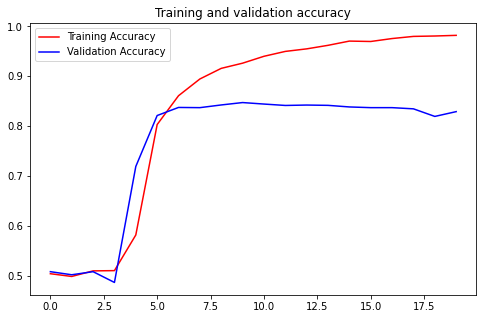

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["Accuracy"], 'r',label = "Training Accuracy")
plt.plot(history["epoch"], history["Val_Accuracy"], 'b', label= "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()


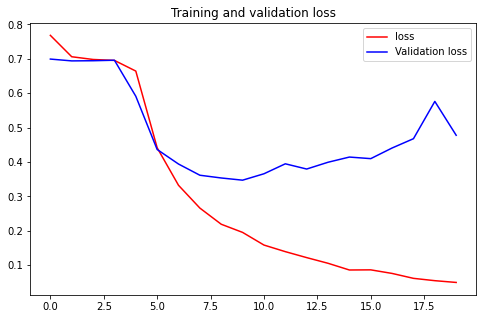

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["loss"], 'r',label = "loss")
plt.plot(history["epoch"], history["Val_loss"], 'b', label= "Validation loss")
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()


In [ ]:
start = time.time()
for (batch, (inp, tar)) in enumerate(dataset_test):
    enc_padding_mask = create_padding_mask(inp)
    logits, _ = model(inp,False, enc_padding_mask)
    test_accuracy.update_state(tar, logits)
print('Accuracy of model on Test : ', test_accuracy.result().numpy())
print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Accuracy of model on Test :  0.8207
Time taken for 1 epoch: 44.85 secs

